In [1]:
import numpy as np
import os
import math
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.ndimage
import skimage
from skimage import io
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_ubyte

import cv2
from albumentations import (
    Compose, HorizontalFlip, ShiftScaleRotate, ElasticTransform,
    RandomBrightness, RandomContrast, RandomGamma, CLAHE
)

import sklearn
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras

import lime
from lime import lime_image

import pandas as pd

gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)

In [2]:
%matplotlib inline

In [3]:
root_folder = "../../2_segmentation/2_Images"

img_size = 300

In [4]:
images_train = []
labels_train = []
for idx, pathogen in enumerate(["Opacity", "COVID-19", "Normal"]):
  for img_filename in os.listdir(os.path.join(root_folder, "train", pathogen)):
    img = cv2.imread(os.path.join(root_folder, "train", pathogen, img_filename), 0)
    img = skimage.img_as_float32(img)
    images_train.append(img)
    labels_train.append(idx)

images_test = []
labels_test = []
for idx, pathogen in enumerate(["Opacity", "COVID-19", "Normal"]):
  for img_filename in os.listdir(os.path.join(root_folder, "test", pathogen)):
    img = cv2.imread(os.path.join(root_folder, "test", pathogen, img_filename), 0)
    img = skimage.img_as_float32(img)
    images_test.append(img)
    labels_test.append(idx)
    
print(len(images_train))
print(len(images_test))

2159
519


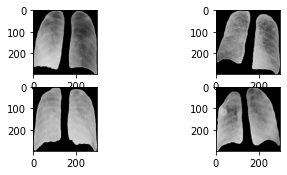

In [5]:
f = plt.figure()
f.add_subplot(3, 2, 1)
plt.imshow(images_train[10], cmap = "gray")
f.add_subplot(3, 2, 2)
plt.imshow(images_train[20], cmap = "gray")
f.add_subplot(3, 2, 3)
plt.imshow(images_test[10], cmap = "gray")
f.add_subplot(3, 2, 4)
plt.imshow(images_test[20], cmap = "gray")

In [6]:
X_train = np.array(images_train).reshape((len(images_train), img_size, img_size))
Y_train = keras.utils.to_categorical(labels_train)
X_train, Y_train = sklearn.utils.shuffle(X_train, Y_train, random_state = 1234)

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.2, random_state = 1234)
X_val = np.stack((X_val,) * 3, axis = -1)

X_test = np.array(images_test).reshape((len(images_test), img_size, img_size))
X_test = np.stack((X_test,) * 3, axis = -1)
Y_test = keras.utils.to_categorical(labels_test)
X_test, Y_test = sklearn.utils.shuffle(X_test, Y_test)

print(np.unique(np.argmax(Y_train, axis = 1), return_counts = True))
print(np.unique(np.argmax(Y_val, axis = 1), return_counts = True))
print(np.unique(np.argmax(Y_test, axis = 1), return_counts = True))

(array([0, 1, 2]), array([739, 315, 673]))
(array([0, 1, 2]), array([189,  93, 150]))
(array([0, 1, 2]), array([231,  95, 193]))


In [7]:
class AugmentationSequence(keras.utils.Sequence):
  def __init__(self, x_set, y_set, batch_size, augmentations):
    self.x, self.y = x_set, y_set
    self.batch_size = batch_size
    self.augment = augmentations

  def __len__(self):
    return int(np.ceil(len(self.x) / float(self.batch_size)))

  def __getitem__(self, idx):
    batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
    batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
    
    aug_x = np.zeros(batch_x.shape)
    for idx in range(batch_x.shape[0]):
      aug = self.augment(image = batch_x[idx,:,:])
      aug_x[idx,:,:] = aug["image"]

    return np.stack((aug_x,) * 3, axis = -1), batch_y

augment = Compose([
  HorizontalFlip(),
  ShiftScaleRotate(shift_limit = 0.05, scale_limit = 0.05, rotate_limit = 15, border_mode = cv2.BORDER_CONSTANT),
  ElasticTransform(sigma = 20, alpha_affine = 20, border_mode = cv2.BORDER_CONSTANT),
  RandomBrightness(),
  RandomContrast(),
  RandomGamma()
])

batch_size = 40
train_generator = AugmentationSequence(X_train, Y_train, batch_size, augment)
steps_per_epoch = math.ceil(X_train.shape[0] / batch_size)

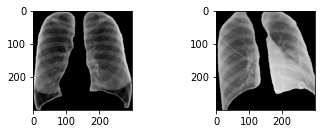

In [8]:
X_aug, Y_aug = train_generator.__getitem__(10)

f = plt.figure()
f.add_subplot(2, 2, 1)
plt.imshow(X_aug[0,:,:,0], cmap = "gray")
f.add_subplot(2, 2, 2)
plt.imshow(X_aug[1,:,:,0], cmap = "gray")

In [9]:
def create_model():
  
  inputs = keras.Input(shape = (img_size, img_size, 3))
  
  base_model = keras.applications.ResNet50V2(
    weights = "imagenet",
    include_top = False,
    input_shape = (img_size, img_size, 3)
  )
  base_model.trainable = False
  
  x = base_model(inputs, training = False)
  x = keras.layers.GlobalAveragePooling2D()(x)
  x = keras.layers.Dense(1024, activation = "relu")(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Dropout(0.5)(x)
  x = keras.layers.Dense(1024, activation = "relu")(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Dropout(0.5)(x)
  x = keras.layers.Dense(512, activation = "relu")(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Dropout(0.5)(x)
  output = keras.layers.Dense(3, activation = 'softmax')(x)

  model = keras.Model(inputs = inputs, outputs = output)

  return model, base_model

In [10]:
reduce_learning_rate = keras.callbacks.ReduceLROnPlateau(
  monitor = "loss", 
  factor = 0.5, 
  patience = 3, 
  verbose = 1
)

model_name = "cache/tl_resnet50v2.h5"

checkpointer = keras.callbacks.ModelCheckpoint(
  model_name,
  monitor = "val_accuracy",
  verbose = 1, 
  save_best_only = True
)

strategy = tf.distribute.MirroredStrategy()

if (os.path.exists(model_name)):
  model = keras.models.load_model(model_name)
  
else:
  with strategy.scope():
    model, base_model = create_model()
    adam_opt = keras.optimizers.Adam(learning_rate = 0.001)
    model.compile(optimizer = adam_opt, loss = "categorical_crossentropy", metrics = ["accuracy"])
    
  fit = model.fit(train_generator, 
    steps_per_epoch = steps_per_epoch, 
    epochs = 50,
    validation_data = (X_val, Y_val),
    callbacks = [
      checkpointer,
      reduce_learning_rate
    ]
  )


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [11]:
model_name = "cache/tl_resnet50v2_finetune.h5"

checkpointer = keras.callbacks.ModelCheckpoint(
  model_name,
  monitor = "val_accuracy",
  verbose = 1, 
  save_best_only = True
)

if (os.path.exists(model_name)):
  model = keras.models.load_model(model_name)
  
else:
  with strategy.scope():
    base_model.trainable = True
    adam_opt = keras.optimizers.Adam(learning_rate = 0.0001)
    model.compile(optimizer = adam_opt, loss = "categorical_crossentropy", metrics = ["accuracy"])
    
  fit = model.fit(train_generator, 
    steps_per_epoch = steps_per_epoch, 
    epochs = 100,
    validation_data = (X_val, Y_val),
    callbacks = [
      checkpointer,
      reduce_learning_rate
    ]
  )

In [12]:
with tf.device("/gpu:1"):
  Y_pred = model.predict(np.stack((X_train,) * 3, axis = -1), batch_size = 16)
  y_pred = np.argmax(Y_pred, axis = 1)
  y_true = np.argmax(Y_train, axis = 1)
  print('Confusion Matrix')
  print(metrics.confusion_matrix(y_true, y_pred))
  print('Classification Report')
  print(metrics.classification_report(y_true, y_pred, target_names = ["Opacity", "COVID-19", "Normal"]))
  print('F-Score')
  print(metrics.precision_recall_fscore_support(y_true, y_pred, average = "macro"))

with tf.device("/gpu:1"):
  Y_pred = model.predict(X_val, batch_size = 16)
  y_pred = np.argmax(Y_pred, axis = 1)
  y_true = np.argmax(Y_val, axis = 1)
  print('Confusion Matrix')
  print(metrics.confusion_matrix(y_true, y_pred))
  print('Classification Report')
  print(metrics.classification_report(y_true, y_pred, target_names = ["Opacity", "COVID-19", "Normal"]))
  print('F-Score')
  print(metrics.precision_recall_fscore_support(y_true, y_pred, average = "macro"))
  
with tf.device("/gpu:1"):
  Y_pred = model.predict(X_test, batch_size = 16)
  y_pred = np.argmax(Y_pred, axis = 1)
  y_true = np.argmax(Y_test, axis = 1)
  print('Confusion Matrix')
  print(metrics.confusion_matrix(y_true, y_pred))
  print('Classification Report')
  print(metrics.classification_report(y_true, y_pred, target_names = ["Opacity", "COVID-19", "Normal"]))
  print('F-Score')
  print(metrics.precision_recall_fscore_support(y_true, y_pred, average = "macro"))

Confusion Matrix
[[736   2   1]
 [  0 314   1]
 [  2   1 670]]
Classification Report
              precision    recall  f1-score   support

     Opacity       1.00      1.00      1.00       739
    COVID-19       0.99      1.00      0.99       315
      Normal       1.00      1.00      1.00       673

    accuracy                           1.00      1727
   macro avg       0.99      1.00      1.00      1727
weighted avg       1.00      1.00      1.00      1727

F-Score
(0.9949500200086874, 0.9961027348678225, 0.995522724534975, None)
Confusion Matrix
[[166  13  10]
 [ 14  75   4]
 [ 12   5 133]]
Classification Report
              precision    recall  f1-score   support

     Opacity       0.86      0.88      0.87       189
    COVID-19       0.81      0.81      0.81        93
      Normal       0.90      0.89      0.90       150

    accuracy                           0.87       432
   macro avg       0.86      0.86      0.86       432
weighted avg       0.87      0.87      0.87      

In [12]:
with tf.device("/gpu:1"):
  Y_pred = model.predict(X_test, batch_size = 16)

i = 1
fpr, tpr, thresholds = roc_curve(Y_test[:, i], Y_pred[:, i])
data = {'fpr': fpr, 'tpr': tpr, 'thresholds': thresholds}
df = pd.DataFrame(data)
df.to_csv("segmented_resnet50v2_roc.csv", index = False)

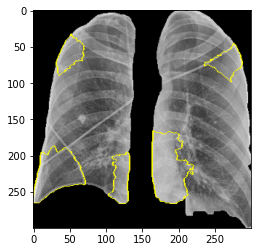

In [13]:
explainer = lime.lime_image.LimeImageExplainer(random_state = 1234)

with tf.device("/gpu:1"):
  explanation = explainer.explain_instance(
    X_test[4,:,:,:], 
    model.predict,
    top_labels = 3,
    hide_color = 0, 
    num_samples = 1000,
    batch_size = 32
  )
  
temp, mask = explanation.get_image_and_mask(
  np.argmax(Y_test[4]), 
  positive_only = True, 
  num_features = 5, 
  hide_rest = False
)

plt.imshow(mark_boundaries(temp, mask))

In [14]:
lime_explain = np.zeros((3, 300, 300))

nimages, _, _, _ = X_test.shape
with tf.device("/gpu:1"):
  for n in range(nimages):
    explanation = explainer.explain_instance(
      X_test[n,:,:,0], 
      model.predict,
      top_labels = 1,
      hide_color = 0, 
      num_samples = 1000,
      batch_size = 32
    )
    
    top_label = explanation.top_labels[0]
    
    temp, mask = explanation.get_image_and_mask(
      explanation.top_labels[0], 
      positive_only = True, 
      num_features = 5, 
      hide_rest = False
    )
    
    lime_explain[top_label,:,:] = np.add(lime_explain[top_label,:,:], mask)
  

<AxesSubplot:>

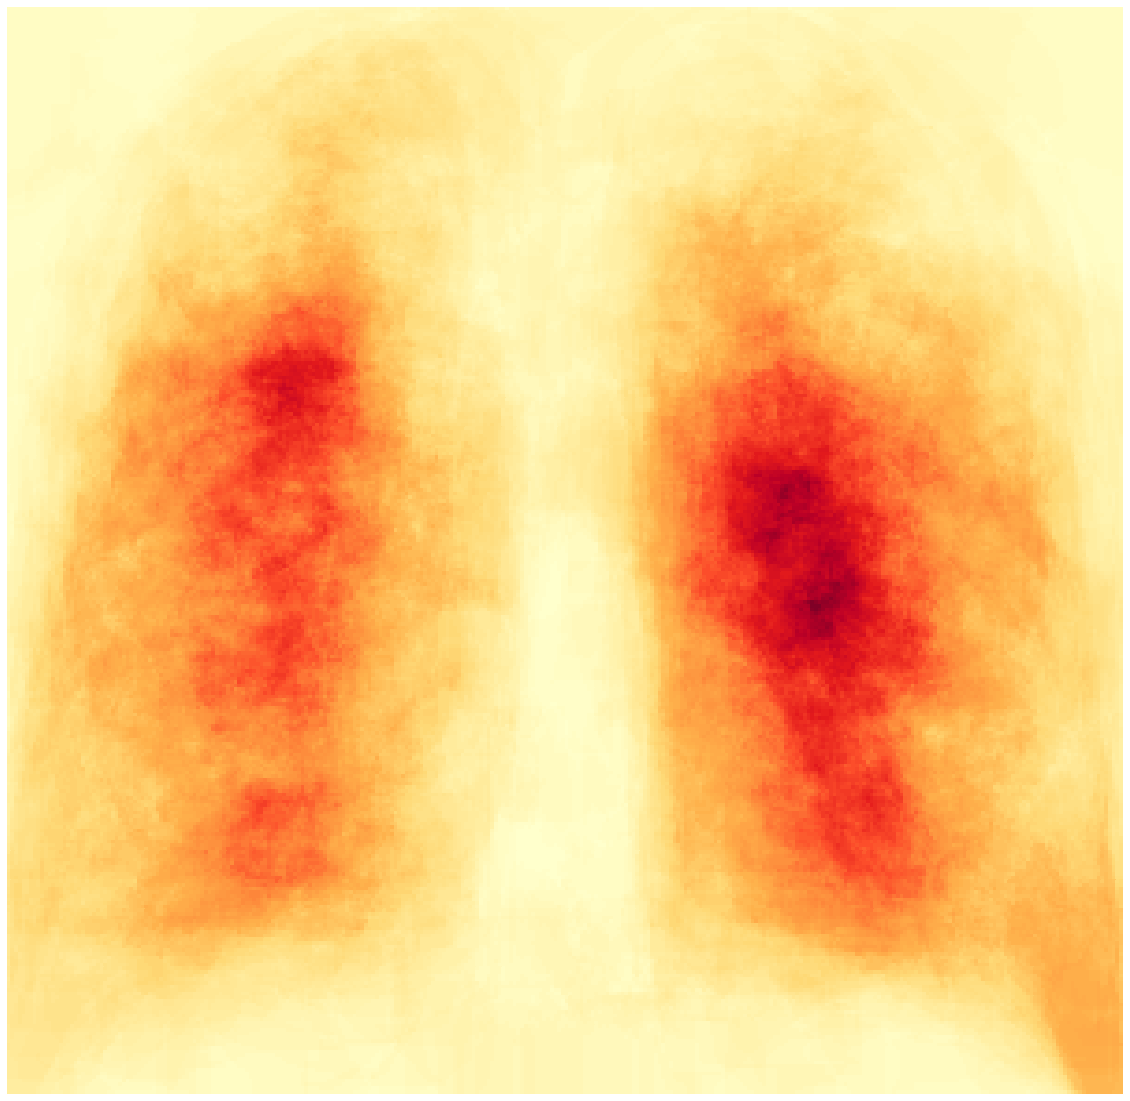

In [15]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 20)
sns.heatmap(lime_explain[0,:,:], cmap = "YlOrRd", xticklabels = False, yticklabels = False, cbar = False)

<AxesSubplot:>

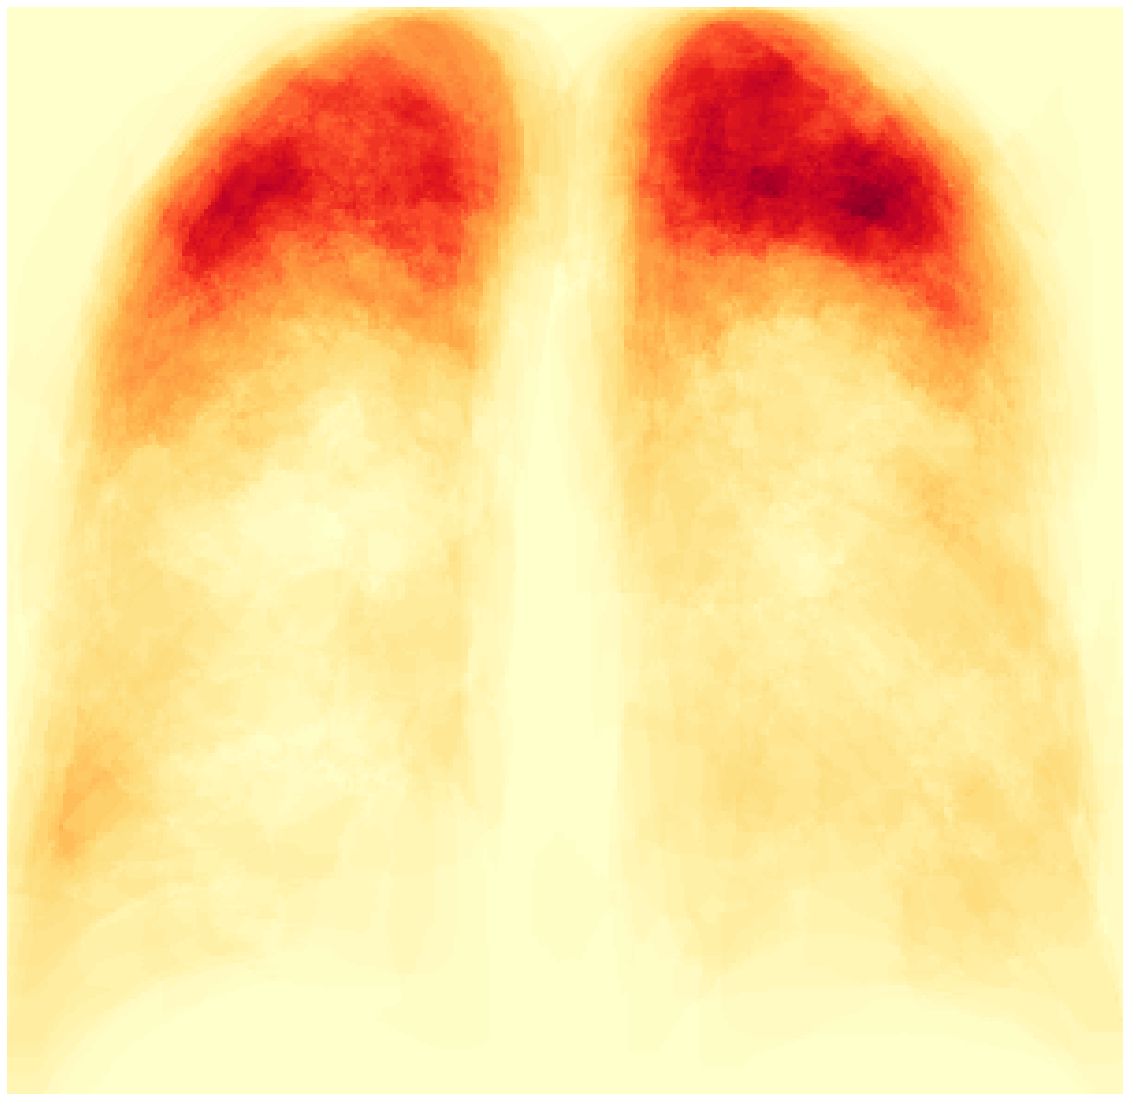

In [16]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 20)
sns.heatmap(lime_explain[1,:,:], cmap = "YlOrRd", xticklabels = False, yticklabels = False, cbar = False)

<AxesSubplot:>

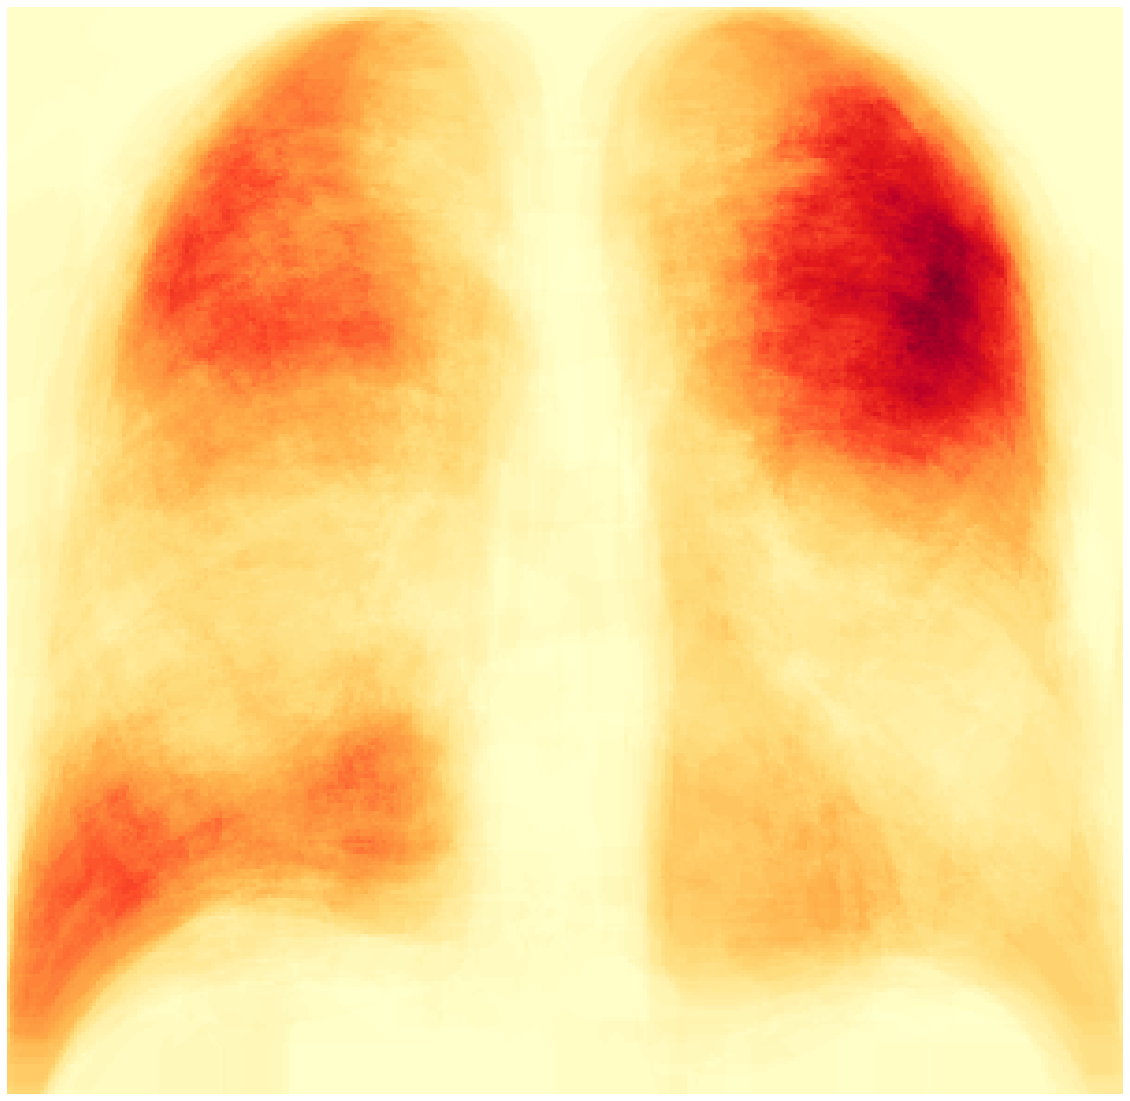

In [17]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 20)
sns.heatmap(lime_explain[2,:,:], cmap = "YlOrRd", xticklabels = False, yticklabels = False, cbar = False)

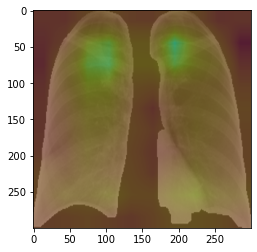

In [16]:
# Grad-CAM
class GradCAM:
  def __init__(self, model, classIdx, baseModel = None, layerName = None):
    # store the model, the class index used to measure the class
    # activation map, and the layer to be used when visualizing
    # the class activation map
    if baseModel:
      self.model = model.get_layer(baseModel)
    else:
      self.model = model
    self.classIdx = classIdx
    self.layerName = layerName
    # if the layer name is None, attempt to automatically find
    # the target output layer
    if self.layerName is None:
      self.layerName = self.find_target_layer()

  def find_target_layer(self):
    # attempt to find the final convolutional layer in the network
    # by looping over the layers of the network in reverse order
    for layer in reversed(self.model.layers):
        # check to see if the layer has a 4D output
        if len(layer.output_shape) == 4:
            return layer.name
    # otherwise, we could not find a 4D layer so the GradCAM
    # algorithm cannot be applied
    raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

  def compute_heatmap(self, image, eps=1e-8):
    # construct our gradient model by supplying (1) the inputs
    # to our pre-trained model, (2) the output of the (presumably)
    # final 4D layer in the network, and (3) the output of the
    # softmax activations from the model
    gradModel = keras.Model(
      inputs=[self.model.inputs],
      outputs=[self.model.get_layer(self.layerName).output,
        self.model.output])

    # record operations for automatic differentiation
    with tf.GradientTape() as tape:
      # cast the image tensor to a float-32 data type, pass the
      # image through the gradient model, and grab the loss
      # associated with the specific class index
      inputs = tf.cast(image, tf.float32)
      (convOutputs, predictions) = gradModel(inputs)
      loss = predictions[:, self.classIdx]
    # use automatic differentiation to compute the gradients
    grads = tape.gradient(loss, convOutputs)

    # compute the guided gradients
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads
    # the convolution and guided gradients have a batch dimension
    # (which we don't need) so let's grab the volume itself and
    # discard the batch
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]

    # compute the average of the gradient values, and using them
    # as weights, compute the ponderation of the filters with
    # respect to the weights
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

    # grab the spatial dimensions of the input image and resize
    # the output class activation map to match the input image
    # dimensions
    (w, h) = (image.shape[2], image.shape[1])
    heatmap = cv2.resize(cam.numpy(), (w, h))
    # normalize the heatmap such that all values lie in the range
    # [0, 1], scale the resulting values to the range [0, 255],
    # and then convert to an unsigned 8-bit integer
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom
    heatmap = (heatmap * 255).astype("uint8")
    # return the resulting heatmap to the calling function
    return heatmap

  def overlay_heatmap(self, heatmap, image, alpha=0.5, colormap=cv2.COLORMAP_VIRIDIS):
    # apply the supplied color map to the heatmap and then
    # overlay the heatmap on the input image
    image = img_as_ubyte(image)
    heatmap = cv2.applyColorMap(heatmap, colormap)
    output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
    # return a 2-tuple of the color mapped heatmap and the output,
    # overlaid image
    return (heatmap, output)


idx = 45
image = X_test[idx:(idx+1),:,:,:]
preds = model.predict(image)
i = np.argmax(preds[0])

cam = GradCAM(model, i, baseModel = "resnet50v2")#, layerName = "mixed10")
heatmap = cam.compute_heatmap(image)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_VIRIDIS)
(heatmap, output) = cam.overlay_heatmap(heatmap, image[0,:,:,:], alpha = 0.3)
plt.imshow(output)

In [18]:
gradcam_explain = np.zeros((3, 300, 300))

nimages, _, _, _ = X_test.shape
with tf.device("/gpu:1"):
  for n in range(nimages):
    image = X_test[n,:,:,:].reshape(1, 300, 300, 3)
    preds = model.predict(image)
    top_label = np.argmax(preds[0])

    cam = GradCAM(model, top_label, baseModel = "resnet50v2")#, layerName = "mixed10")
    heatmap = cam.compute_heatmap(image)
    heatmap = heatmap / 255
    
    gradcam_explain[top_label,:,:] = np.add(gradcam_explain[top_label,:,:], heatmap)
    

<AxesSubplot:>

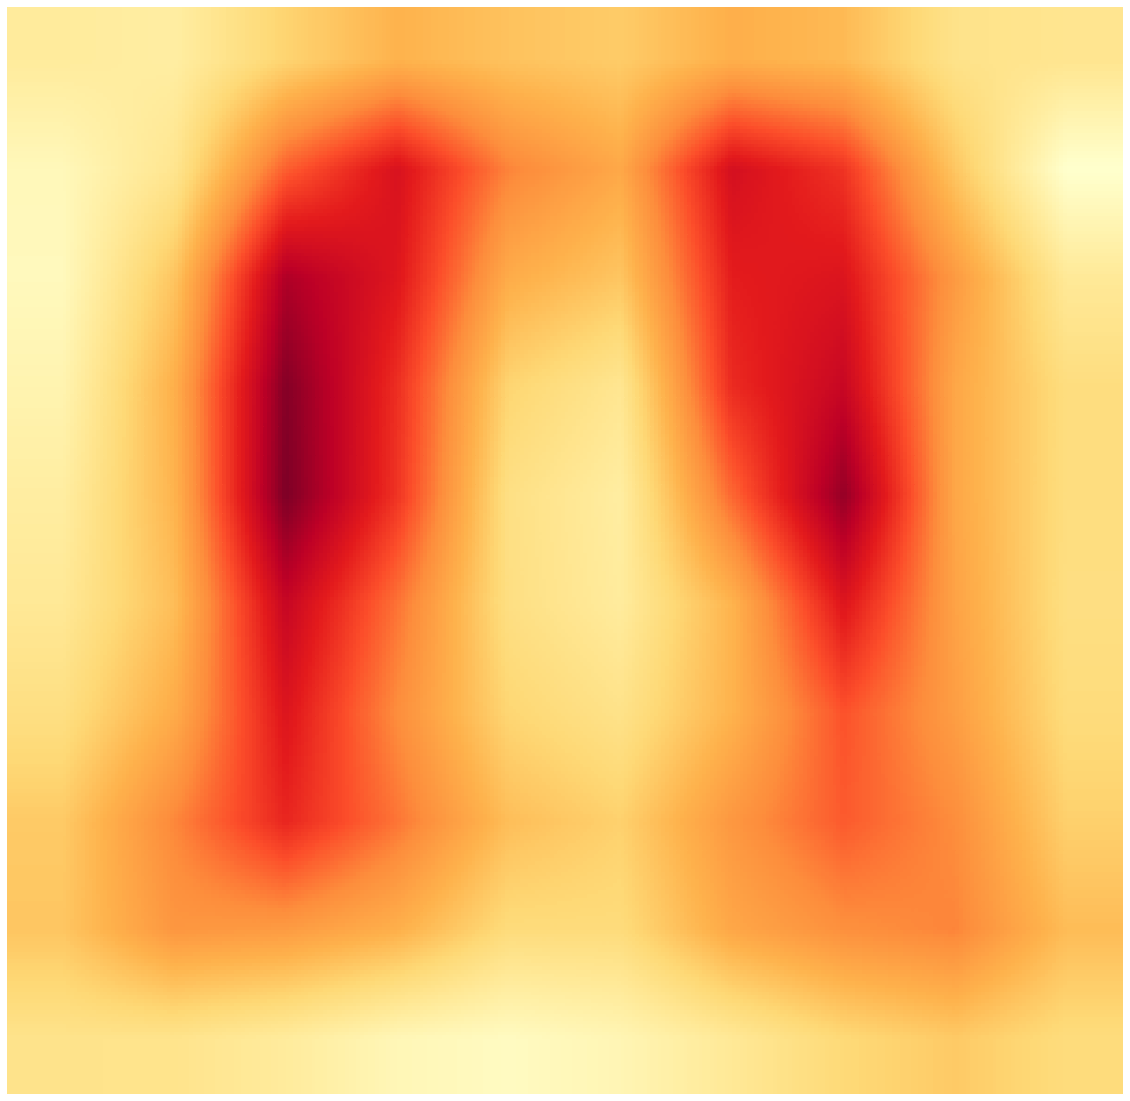

In [19]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 20)
sns.heatmap(gradcam_explain[0,:,:], cmap = "YlOrRd", xticklabels = False, yticklabels = False, cbar = False)

<AxesSubplot:>

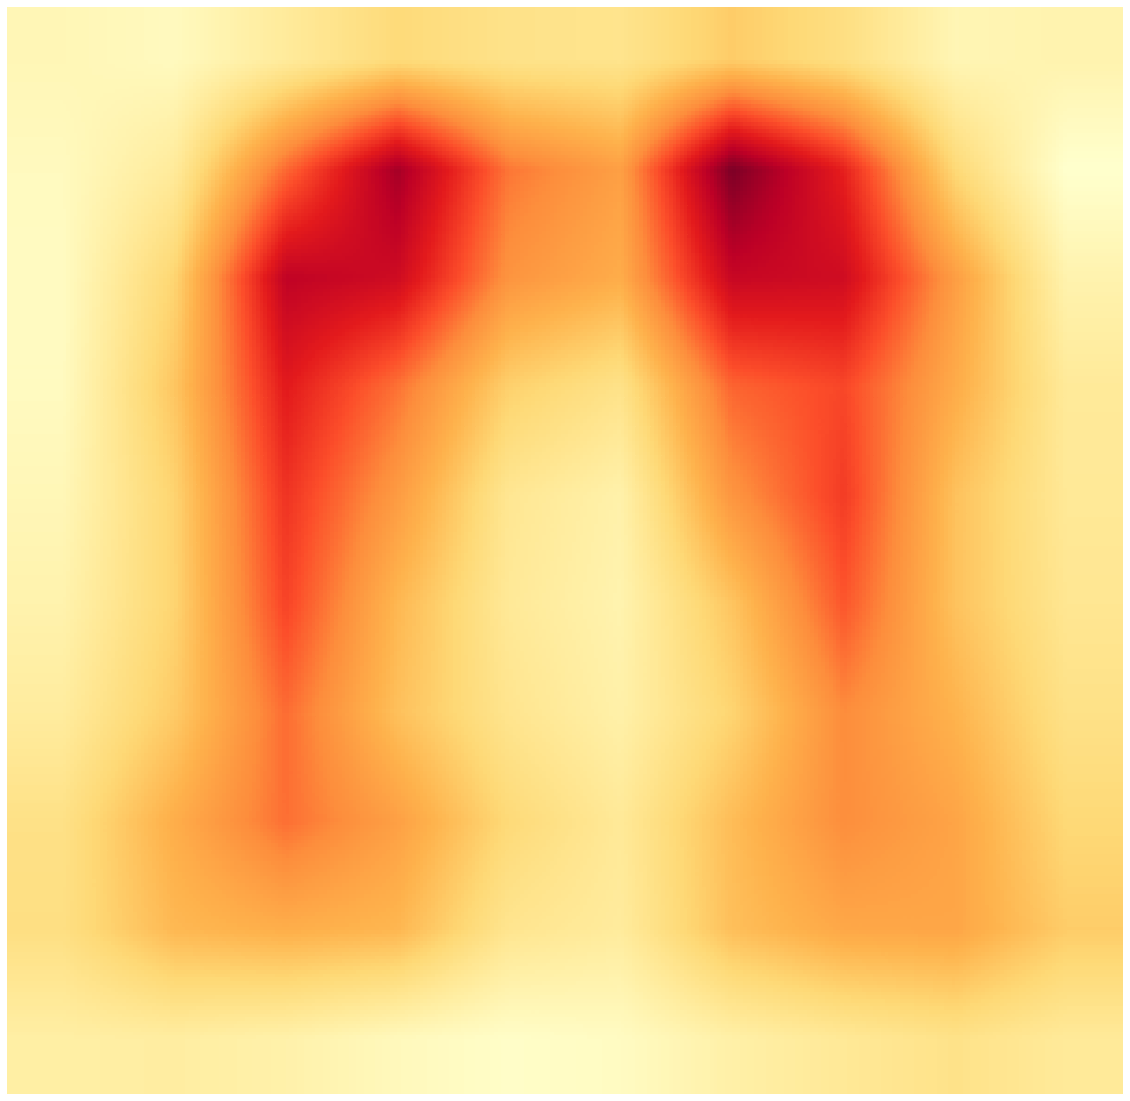

In [20]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 20)
sns.heatmap(gradcam_explain[1,:,:], cmap = "YlOrRd", xticklabels = False, yticklabels = False, cbar = False)

<AxesSubplot:>

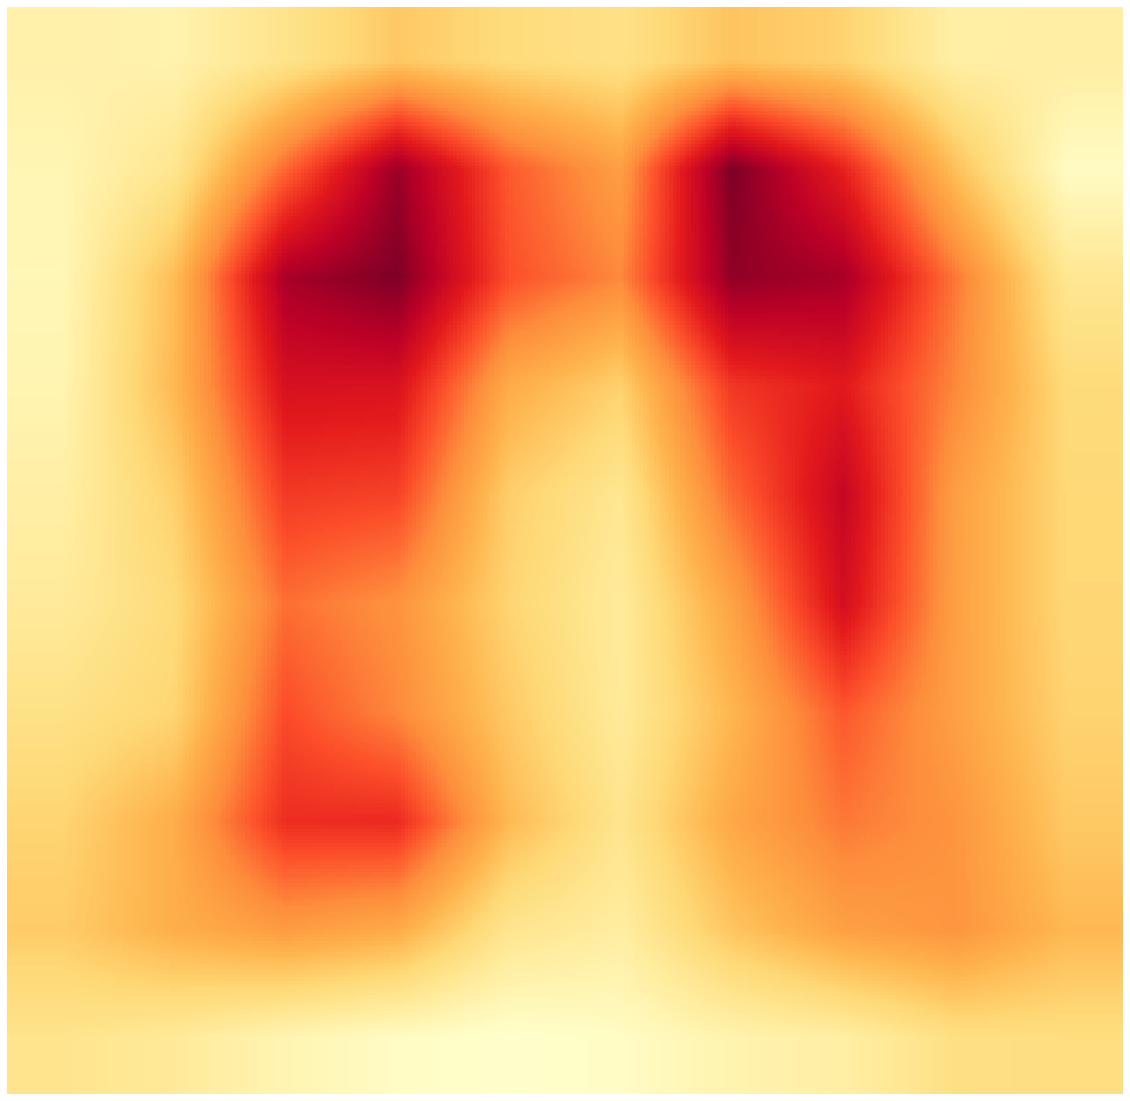

In [21]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 20)
sns.heatmap(gradcam_explain[2,:,:], cmap = "YlOrRd", xticklabels = False, yticklabels = False, cbar = False)